In [5]:
!git clone https://github.com/anminhhung/small_dog_cat_dataset

Cloning into 'small_dog_cat_dataset'...
remote: Enumerating objects: 2608, done.
remote: Total 2608 (delta 0), reused 0 (delta 0), pack-reused 2608
Receiving objects: 100% (2608/2608), 55.84 MiB | 17.40 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [7]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset, SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision import datasets, transforms 
from torchvision.models import resnet18
import torchvision 
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import cv2
import os

import albumentations

In [86]:
'''
    Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)

'''
    Function for plotting training and validation losses
'''
def plot_losses(train_acc, valid_acc, train_loss, valid_loss):
    # change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(train_acc, color="blue", label="Train_acc")
    ax1.plot(valid_acc, color="red", label="Validation_acc")
    ax1.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax1.legend()

    ax2.plot(train_loss, color="blue", label="Train_loss")
    ax2.plot(valid_loss, color="red", label="Validation_loss")
    ax2.set(title="loss over epochs",
            xlabel="Epoch",
            ylabel="Loss")
    ax2.legend()

    fig.show()

    # change the plot style to default
    plt.style.use('default')

'''
    function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss 

'''
    function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

'''
    function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, fold_idx, print_every=1):
    if not os.path.exists("save_model"):
      os.mkdir("save_model")
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    # train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

            # save model
            # if train_acc > best_acc: => moi luu 
            torch.save(model.state_dict(), "save_model/fold_{}_epoch_{}_acc{}.pth".format(fold_idx+1, epoch, valid_acc))
            # best_acc = train_acc
            # print("[INFO] save_model/fold_{}_epoch_{}_acc{}.pth".format(fold_idx+1, epoch, valid_acc))

    plot_losses(list_train_acc, list_val_acc, train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [105]:
class DogCatDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.list_images_path = []
    self.list_labels = []
    self.one_hot_label = {"dogs": 0, "cats": 1}
    for sub_dir in os.listdir(root_dir):
      path_sub_dir = os.path.join(root_dir, sub_dir)
      for image_name in os.listdir(path_sub_dir):
        image_path = os.path.join(path_sub_dir, image_name)
        label = sub_dir
        self.list_images_path.append(image_path)
        self.list_labels.append(label)
    
    self.transform = transform
  
  def __len__(self):
    return len(self.list_images_path)
  
  def __getitem__(self, idx):
    image = cv2.imread(self.list_images_path[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    label = np.array(self.one_hot_label[self.list_labels[idx]]) # .astype('float')

    if self.transform:
      res = self.transform(image=image)
      image = res['image'].astype(np.float32)
    else:
      image = image.astype(np.float32)
    
    image = image.transpose(2, 0, 1)
    sample = (image, label)

    return sample # image, label

In [106]:
def get_transforms(image_size=(224, 224)):

    transforms_train = albumentations.Compose([
        albumentations.HorizontalFlip(p=0.5),
        albumentations.ImageCompression(quality_lower=99, quality_upper=100),
        albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
        # albumentations.Resize(image_size, image_size),
        # albumentations.Cutout(max_h_size=int(image_size * 0.4), max_w_size=int(image_size * 0.4), num_holes=1, p=0.5),
        albumentations.Normalize()
    ])

    transforms_val = albumentations.Compose([
        # albumentations.Resize(image_size, image_size),
        albumentations.Normalize()
    ])

    return transforms_train, transforms_val

In [107]:
transforms_train, transforms_val = get_transforms(image_size=(224, 224))

In [108]:
transformed_train_data = DogCatDataset('small_dog_cat_dataset/train', transform=transforms_train)
transformed_test_data = DogCatDataset('small_dog_cat_dataset/test', transform=transforms_val)

In [109]:
def setup_dataflow(dataset, train_idx, val_idx):
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)
  
    return train_loader, val_loader

In [110]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.model = resnet18(num_classes=2)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        return self.model(x)

In [111]:
num_folds = 5
splits = KFold(n_splits=num_folds,shuffle=True,random_state=42)

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

############### Fold 1 ###############
Epochs: 0, Train_loss: 0.6944914019107818, Valid_loss: 0.6541186616970942, Train_accuracy: 59.25, Valid_accuracy: 61.5
Epochs: 1, Train_loss: 0.6409184670448304, Valid_loss: 0.6357938555570749, Train_accuracy: 63.5, Valid_accuracy: 65.5
Epochs: 2, Train_loss: 0.6254444128274917, Valid_loss: 0.6350718369850745, Train_accuracy: 65.1875, Valid_accuracy: 60.25
Epochs: 3, Train_loss: 0.6086769634485245, Valid_loss: 0.6055866846671472, Train_accuracy: 69.0, Valid_accuracy: 70.0
Epochs: 4, Train_loss: 0.5936596399545669, Valid_loss: 0.5695988581730769, Train_accuracy: 69.8125, Valid_accuracy: 71.5
Epochs: 5, Train_loss: 0.5593057608604431, Valid_loss: 0.6235665518503922, Train_accuracy: 69.1875, Valid_accuracy: 66.0
Epochs: 6, Train_loss: 0.5527389794588089, Valid_loss: 0.5782036070640271, Train_accuracy: 74.0, Valid_accuracy: 71.0
Epochs: 7, Train_loss: 0.5335139709711075, Valid_loss: 0.5805851129385141, Train_accuracy: 76.25, Valid_accuracy: 71.5
Epoch

<ipython-input-86-aa7372f41059>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epochs: 0, Train_loss: 0.6754171562194824, Valid_loss: 0.6590035970394428, Train_accuracy: 63.375, Valid_accuracy: 62.5
Epochs: 1, Train_loss: 0.6376815134286881, Valid_loss: 0.7159169087043176, Train_accuracy: 65.4375, Valid_accuracy: 60.5
Epochs: 2, Train_loss: 0.6219338482618332, Valid_loss: 0.6448855308385996, Train_accuracy: 66.4375, Valid_accuracy: 59.0
Epochs: 3, Train_loss: 0.6098651868104935, Valid_loss: 0.6064227750668159, Train_accuracy: 66.875, Valid_accuracy: 63.5
Epochs: 4, Train_loss: 0.6004237252473831, Valid_loss: 0.6497351160416236, Train_accuracy: 70.3125, Valid_accuracy: 70.0
Epochs: 5, Train_loss: 0.5607399314641952, Valid_loss: 0.6566040149101844, Train_accuracy: 71.25, Valid_accuracy: 66.0
Epochs: 6, Train_loss: 0.5544935631752014, Valid_loss: 0.8250346275476309, Train_accuracy: 57.62500000000001, Valid_accuracy: 54.0
Epochs: 7, Train_loss: 0.5375478708744049, Valid_loss: 0.6004555087823135, Train_accuracy: 74.75, Valid_accuracy: 70.5
Epochs: 8, Train_loss: 0.536

<ipython-input-86-aa7372f41059>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epochs: 0, Train_loss: 0.6829217040538788, Valid_loss: 0.647471567759147, Train_accuracy: 62.31250000000001, Valid_accuracy: 57.49999999999999
Epochs: 1, Train_loss: 0.6455722868442535, Valid_loss: 0.7078834497011625, Train_accuracy: 60.0, Valid_accuracy: 55.75
Epochs: 2, Train_loss: 0.6379733502864837, Valid_loss: 0.6311963475667514, Train_accuracy: 65.0625, Valid_accuracy: 65.25
Epochs: 3, Train_loss: 0.598074694275856, Valid_loss: 1.0157700066383069, Train_accuracy: 59.5, Valid_accuracy: 61.0
Epochs: 4, Train_loss: 0.5890168178081513, Valid_loss: 0.6837064440433795, Train_accuracy: 68.25, Valid_accuracy: 63.74999999999999
Epochs: 5, Train_loss: 0.5625177627801895, Valid_loss: 0.7005560443951533, Train_accuracy: 71.375, Valid_accuracy: 63.74999999999999
Epochs: 6, Train_loss: 0.5514715898036957, Valid_loss: 0.6716013344434592, Train_accuracy: 69.25, Valid_accuracy: 68.75
Epochs: 7, Train_loss: 0.5194664341211319, Valid_loss: 0.518500016285823, Train_accuracy: 77.8125, Valid_accuracy:

<ipython-input-86-aa7372f41059>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epochs: 0, Train_loss: 0.6719933819770812, Valid_loss: 0.6872150806280283, Train_accuracy: 57.9375, Valid_accuracy: 55.75
Epochs: 1, Train_loss: 0.6458492410182953, Valid_loss: 0.6362577997721158, Train_accuracy: 66.3125, Valid_accuracy: 63.24999999999999
Epochs: 2, Train_loss: 0.6097516334056854, Valid_loss: 0.6577723278449132, Train_accuracy: 68.4375, Valid_accuracy: 63.5
Epochs: 3, Train_loss: 0.5982945513725281, Valid_loss: 0.5974966035439417, Train_accuracy: 69.0625, Valid_accuracy: 68.25
Epochs: 4, Train_loss: 0.5889845603704452, Valid_loss: 0.6652151644229889, Train_accuracy: 65.125, Valid_accuracy: 62.25000000000001
Epochs: 5, Train_loss: 0.5772399115562439, Valid_loss: 0.9376851732914264, Train_accuracy: 61.9375, Valid_accuracy: 57.99999999999999
Epochs: 6, Train_loss: 0.570121408700943, Valid_loss: 0.6653465995421777, Train_accuracy: 70.0625, Valid_accuracy: 66.5
Epochs: 7, Train_loss: 0.5406285136938095, Valid_loss: 0.5983250645490793, Train_accuracy: 74.375, Valid_accuracy:

<ipython-input-86-aa7372f41059>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epochs: 0, Train_loss: 0.6797344601154327, Valid_loss: 0.6290744543075562, Train_accuracy: 63.5625, Valid_accuracy: 65.0
Epochs: 1, Train_loss: 0.6392095899581909, Valid_loss: 0.7288285402151254, Train_accuracy: 59.0, Valid_accuracy: 59.5
Epochs: 2, Train_loss: 0.6178339785337448, Valid_loss: 0.722732947422908, Train_accuracy: 63.0, Valid_accuracy: 60.0
Epochs: 3, Train_loss: 0.5976507985591888, Valid_loss: 0.6393401324748993, Train_accuracy: 69.4375, Valid_accuracy: 61.0
Epochs: 4, Train_loss: 0.5728701764345169, Valid_loss: 0.714146219767057, Train_accuracy: 60.4375, Valid_accuracy: 62.25000000000001
Epochs: 5, Train_loss: 0.5585675972700119, Valid_loss: 0.777044204565195, Train_accuracy: 66.8125, Valid_accuracy: 59.0
Epochs: 6, Train_loss: 0.5407954168319702, Valid_loss: 0.6784065686739408, Train_accuracy: 73.6875, Valid_accuracy: 67.5
Epochs: 7, Train_loss: 0.5287862259149552, Valid_loss: 0.5662603997267209, Train_accuracy: 75.8125, Valid_accuracy: 72.75
Epochs: 8, Train_loss: 0.50

<ipython-input-86-aa7372f41059>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


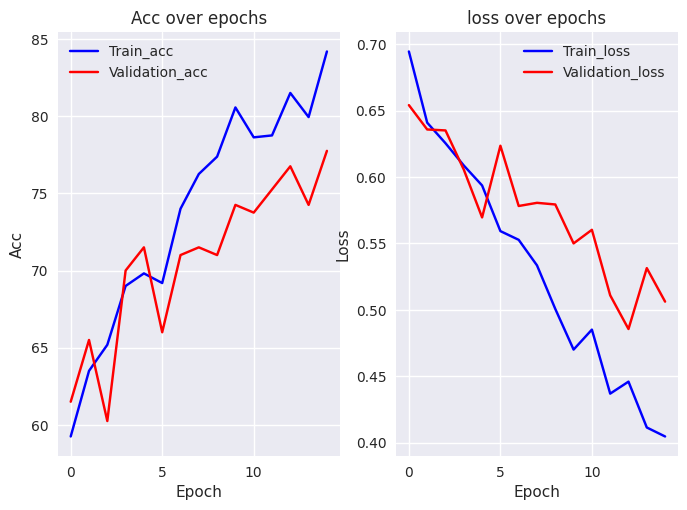

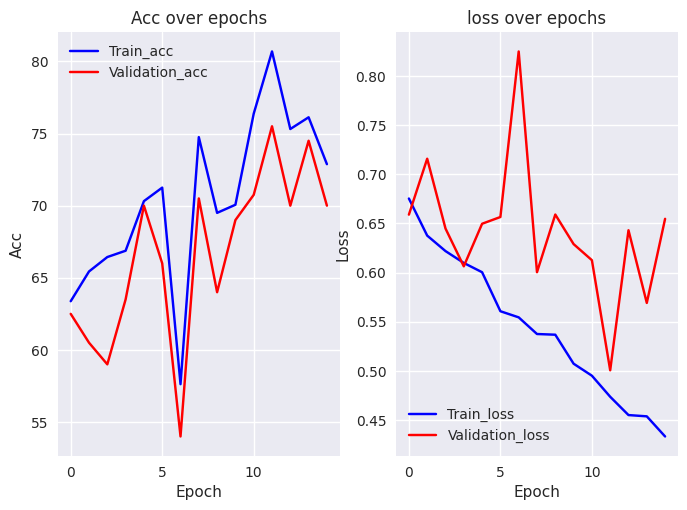

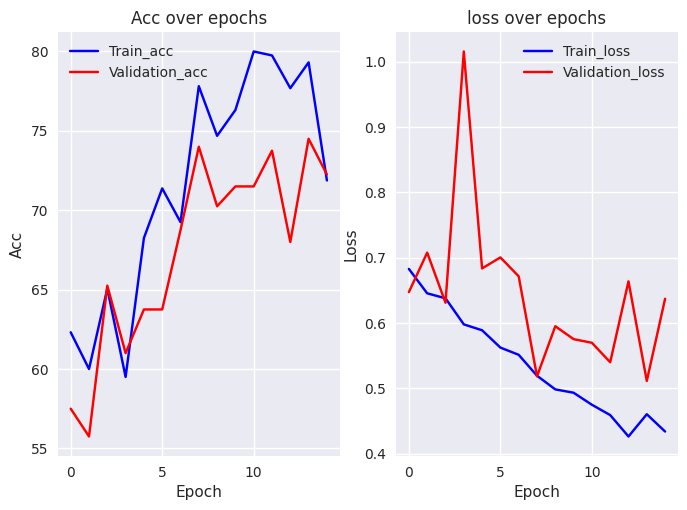

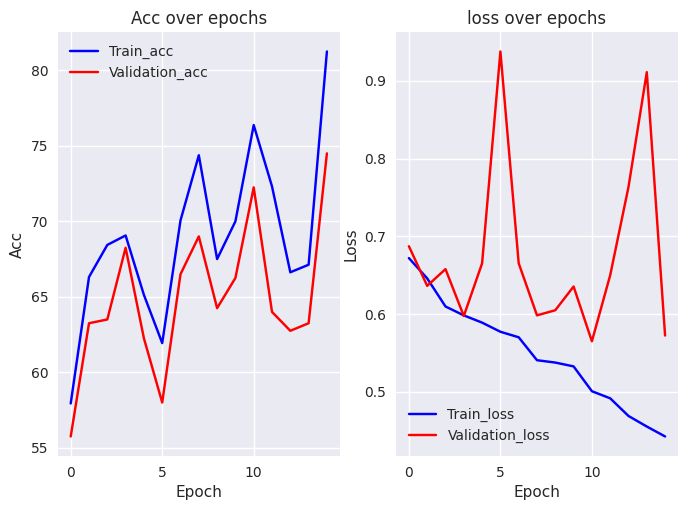

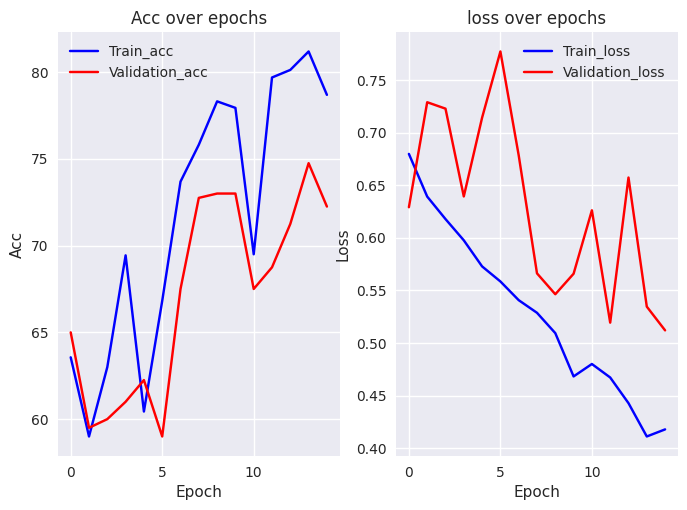

In [113]:
for fold_idx, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(transformed_train_data)))):
  print('############### Fold {} ###############'.format(fold_idx + 1))
  train_loader, val_loader = setup_dataflow(transformed_train_data, train_idx, val_idx)
  model = Net().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # 0.0001 
  loss_function = nn.CrossEntropyLoss()
  model, optimizer, _ = training_loop(model, loss_function, optimizer, train_loader, val_loader, 15, device, fold_idx)
